# Techical Report - RE Investment Application

## Problem Statement

Given a property address can relevant rental amounts be found for the propety? According to the location of the property and user provided financial information can a model be developed for predicting the approval of a potential mortgage loan?  

## Overview

Many real estate applications on the market do not service the real estate investor. An investor needs to know relevant property information AND rental information. The goal of this application is to pair real estate property data with the rental market information and loan terms. Given these three elements a real estate investor can make a more educated decision on which properties to purchase. 

#### Application Process
 1) The application first collects the property address from the user. <br>
 2) The address information is collected from the ATTOM api.<br>
 3) The aproximate rental amount is collected from the 2020 HUD Fair Market Rent Report based on the county.<br>
 4) The cost of the property and the potential rental income is calculated and a several real estate investment metrics are calculated.<br>
 5) The property information and the user's financial information are fed into a Nueral Network.<br>
 6) The Nueral Network provide the likelihood that the investor will be approved or denied for the mortgage loan of that particular property.<br>

## Data

#### Property Record & Attributes

The ATTOM Data "All Records" api call is utilized to collect the public information and property feature information. 

https://api.developer.attomdata.com/

#### Fair-Market-Rental Values

The County Level Fair Market Rents FY 2020 dataset was used for rental figures. This dataset provides FMR figures for 0-4 bedroom homes per county. 

https://www.huduser.gov/portal/datasets/fmr.html#2020_data

#### Mortgage Records

The 2018 Loan/Applications Records dataset from the FFIEC was used for mortgage approval history. The Home Mortgage Disclosure Act requires every lending institution to report applications for home mortgages and whether the application was approved. This dataset also contained census tract information for every loan application.

https://ffiec.cfpb.gov/data-publication/dynamic-national-loan-level-dataset/2018

***The data fields collected from these APIs and datasets are listed in the data dictionary included in this repository.***

### The Data Flow

These three datasets each work together to provide the database for the application to run. 

--> From **ATTOM** the *proprty profile* is built. 

----> From the *property profile*, the county and bedroom count is pulled. 

------> Using the county and bedroom values, the Fair Market Rent is pulled from the **Fair Market Rents FY 2020 dataset** and added to the *property profile*

--------> The **2018 Loan/Applications Records** dataset was used to train the mortgage loan approval predictive model

----------> From the **2018 Loan/Applications Records** dataset the census tract data fields are applied to the *property profile*

------------> User fields are provided and added to the *property profile* 

--------------> The complete *property profile* is run through the mortgage approval model and a prediction is generated

----------------> The real estate calculations are made from the *property profile* and displayed.


## Assumptions & EDA

### Assumptions

#### 1) Fair Lending
The 2018 Loan/Applications Records dataset originally contained demographic values including race, ethnicity, and sex. These are likely included in the data to allow for the study of potential discrimination. For this project all race, ethnicity, and sex data was excluded. The assumption made is that finacial institutions are complying to fair-lending standards and that discrimination is not present. The truth of that assumption was not the goal of this project. There is a chance that discrimination is present in the data and this could have an impact on the model's effectiness in predicting morgage approvals in certian geo-local areas.

#### 2) Single Family Property
The application assumes that each property evaluated is a single family (one-unit) property. This limits the application from being used on more than one-unit properties. 

### Exploratory Data Analysis

#### 1) Loan Type

The 2018 Loan/Applications Records dataset originally contained multiple mortgage/loan options. For the purpose of this project only **"first position lien home purchase"** mortgages were considered. All other types were discarded. 

1 - Home purchase <br>
2 - Home improvement <br>
31 - Refinancing <br>
32 - Cash-out refinancing <br>
4 - Other purpose <br>
5 - Not applicable <br>

#### 2) Business or Commercial Purpose

For this project only person loan applications were analyzed, all other types were excluded. 

#### 3) Lack of Debt-to-Income Data

Over 50% of the debt-to-income ratio data was null. It was excluded from the model. This factor has a large effect on the approval of a mortgage loan. The decision to keep the bulk of the data rather than the debt-to-income values was chosen. This may negatively affect the realistic usability of the model and in future developments of this analysis it should be considered for use. 

## Model Targets

The target of the model was to accurately predict whether an applicant would be approved or denied for a mortgage loan. The data set originally provided the below denial reasons:

1 - Debt-to-income ratio<br>
2 - Employment history<br>
3 - Credit history<br>
4 - Collateral<br>
5 - Insufficient cash (downpayment, closing costs)<br>
6 - Unverifiable information<br>
7 - Credit application incomplete<br>
8 - Mortgage insurance denied<br>
9 - Other<br>
10 - Not applicable <br>

"Not applicable" is the status given for an approved loan. 

Categorical models were first applied to all of the loan denial codes. *The distribution of each of these is displayed below.* 

**Note**: The loan "approval" instances are removed from this histogram. They accounted for 90.4426% of the data set. 

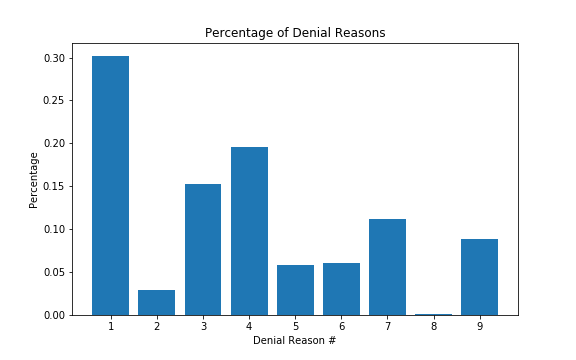

In [2]:
from IPython.display import Image 

Image("images/target_dist.png")

Again, the proportion of target value "approval" was 90.4426% this sets the baseline of the model accuracy. In order for any model to be successful it will need to make predictions with greater than 90.5% accuaracy. 

After several models were created to predict these 10 targets the maximum accuracy score was 92.224%. See more detailed information in the Modeling section.

After further analysis of the targets a binomial target was created. All denial reasons were categorized together into simpy a "denied" category. *See the distribution of these classes below.* This helped simplify the model predictions and also slighlty improved the issue of unbalanced classes. By combining all of the denial reasons they now accounted for almost 10% of the observations were before this number was fragmented over 9 categories.

This decision also made logical sense as many of the denial reasons were questionable as to whether a model can accurately predict that particular outcome given it's limited inputs. Take for example "Credit application incomplete" or "Unverifiable information" denial reasons. While these are valid denial reasons they may not be as relevant to the information the model is provided. Each instance of the model is provided a complete dataset so it is tough to have it predict an "incomplete application". By combining these denial reasons into simply one denial classification this helps generalize the model predictions to the data and helps alliviate this shortoming of the model design. 

The targets were converted to a binary classification:

0 = Loan Not Approved <br>
1 = Loan Approved

After the binary classification was created several models were tested. The accuracy score improved from 92.224% to 94.151%. See more information in the Modeling section.

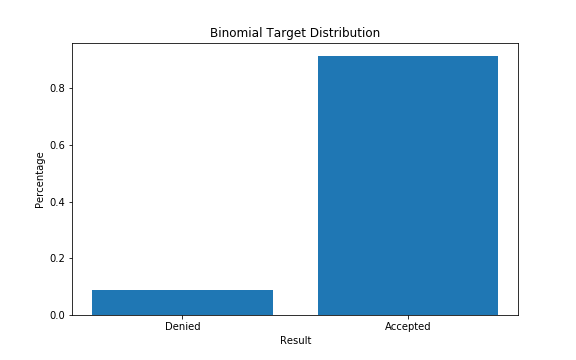

In [3]:
Image("images/binomial_target.png")

## Modeling 

While modeling best practices were adhered to. The data was randomly split into a training set consisting of 75% of the data and a training set of 25% of the data. The target variable was stratified between the two. Cross validation was also utilized to correct for any potential randomness of results that could occur. 

### Logistic Regression - Classification

A logistic regression classifier model was fit to both the 10 classification and 2 classification targets. 

10 Class Accuracy Score: 91.276%

2 Class Accuracy Score: 91.276%

Each logistic regression model used an L2 (Ridge) regularization penalty 

### Nueral Net - Classification

Multiple Nueral Net models were fit to both the 10 classification and 2 classification targets. Datasets were scaled prior to modeling. Grid search was utilized to find the best combination of epochs, layer one nodes, layer two nodes, and the dropout rate. The best two models are provided below. 

**10 Class:** <br>
Accuracy: 92.11% 

**Buildout:** <br>
Layer 1: 128 nodes <br>
Dropout: 50% <br>
Layer 2: 24 nodes <br>
Output layer: 11 nodes <br>
Epochs: 200 <br>
Batch: 512

**2 Class:**
Accuracy: 94.15%

**Buildout:** <br>
Layer 1: 128 nodes <br>
Dropout: 50% <br>
Layer 2: 24 nodes <br>
Output layer: 2 nodes <br>
Epochs: 100 <br>
Batch: 512


The 2 Class Nueral Net performed the best with the above hyper-parameters. The Adam loss function that was optimized. See the plot below for representation of this function. 

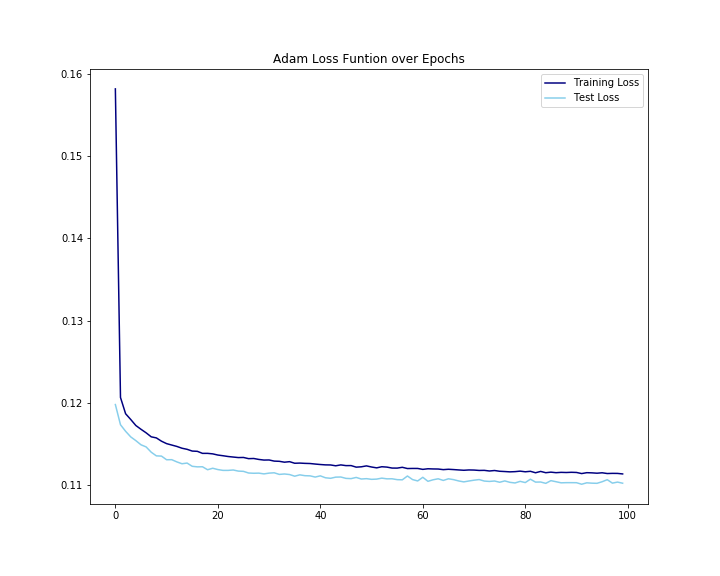

In [7]:
Image("images/best_model_loss.png")

## Results

After several model types and many hyper-parameter tunings the best overall accuracy score was 94.15%. That is 3.71% better than the baseline. The best model was found to be a Nueral Network with two hidden layers of 128 and 24 nodes. 

To continue to improve upon this score more feature engineering should be performed on the data to increase the number of inputs to the model. The unbalanced targets should also be addressed. These changes are necissary to continue to increase the model accuracy. More complex nueral networks with more than 2 hidden layers were created and accuracy did not increase, leading the conclusing to be that there needs to be more data input not more complex models. 

## Application

The application calculates several standard real estate investing calculations to provide the user information about the potential returns on investment they can expect from a given property. 

#### Inputs & Variables Used

**mti** = Monthly Total Income (total income of property including all units and aux services)

**vr** = Vacancy Rate (percentage of income held out to cover costs of vacant unit, typically 5% of mti) 

**er** = Expense Reserves (Maintenance and Capital Improvements, usually 10-25% of mti)

**me** = Monthly Expenses (landlord paid expenses, typically water and trash)

**mfc** = Monthly Financing Cost (principle and interest payments)

**mt** = Monthly Taxes (annual tax / 12)

**mi** = Monthly Insurance (annual insurance cost / 12) 

**tci** = Total Cash Invested (amount of money initially put into deal

**price** = Price of Property

### Cashflow Calculation

**mcf** = Monthly Cashflow (mti - vr - er - me - mfc - mt - mi)

**acf** = Annual Cashflow (mcf * 12)

### Cash on Cash Return (COC) Calculation

**coc** = Cash On Cash (acf / tci) * 100 

### Capitalization Rate (Cap Rate) Calculation

**cr** = ((mti - vr - er - me - mt - mi) * 12) / price

### ATTOM Data Property Valuation

ATTOM's api provides a general property valuation for three tiers of quality of a given subject Property. They have a proprietary algorithm that will assign a property a valuation based on up to 100 property comparables sold in the last year in the area of the subject property. 

**Valuation Tiers:**
- Poor Condition
- Average Condition
- Good Condition

These valuations are provided to the user to help them get an idea of whether or not the property they are analyzing is priced realistically and fairly. 

## Continued Work & Ideas for Improvement

This analysis could be continued and improved upon with the following items/elements:

#### Balance the mortgage approval targets
The data set used to predict whether a mortgage loan would be approved or not contained very unbalanced classes. Only about 10% of the loan applications in the data set were denied. Balancing that ratio to more of a 50/50 likely will increase the signal to the future model and provide more accuracy. 

#### Credit Score and Debt-to-Income
The data set used to predict whether a mortgage loan would be approved or not did not contain credit scores. This element is a large factor a lender will take into consideration when deciding to approve or deny a loan application. For improved model performance and overall for a more realistic modeling situation an applicants credit score should be considered. 

The dataset also contained more than 50% null values in the debt-to-income category. Much like credit score, this factor has a huge impact on whether or not an applicant is approved for a mortgage loan. Lending standards limit the maximum debt-to-income limit at 50%. This factor would be nice to include in a future model and likeliy improve the model's accuracy. 

#### Neighborhood Specific Rental Figures
The data provided by the Fair Market Rents FY 2020 dataset was limited to a general county rental figure. With many counties, especially those located in an urban center, they often contain many neighborhoods and differing regions. These neighborhoods oftentimes fetch higher or lower rental amounts based on many local factors. To improve the effectivness of this application the more specific and acurate the rental figure is the more accurate the whole application becomes. 

#### Multiple Unit Analysis
Many of the properties contained in the datasets contain multiple units such as a duplex containing two income producing units. The application is currently limited to only single units. To improve the overall usefullness of the application, calculations for multiple units within one address could be added.


# Data Dictionary